# Env Setup

In [1]:
!git clone https://github.com/Zack-szh/EECS442_Final_Project.git

Cloning into 'EECS442_Final_Project'...
remote: Enumerating objects: 30113, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 30113 (delta 43), reused 41 (delta 14), pack-reused 30026 (from 3)
Receiving objects: 100% (30113/30113), 78.34 MiB | 13.03 MiB/s, done.
Resolving deltas: 100% (4664/4664), done.
Updating files: 100% (30012/30012), done.


In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Load Image

In [3]:
def load_img(img_path, greyscale=False):
    """ This function serves as a dataloader, loads img from img_path as grayscale """
    flag = cv2.IMREAD_ANYCOLOR
    if greyscale:
        flag = cv2.IMREAD_GRAYSCALE
    img = cv2.imread(img_path, flag)    # loads img as grayscale, one channel to work with

    if img is None:
        raise FileNotFoundError(f"File not found at: {img_path}")

    return img

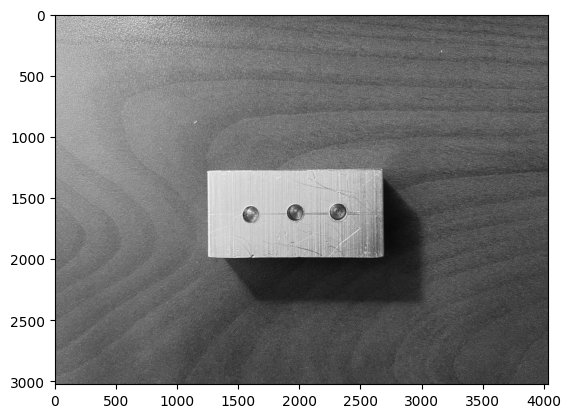

In [4]:
base_path = "./EECS442_Final_Project"

img_path = os.path.join(base_path, "data", "physical parts", "Basic II base part.jpg")
# img_path = os.path.join(base_path, "data", "physical parts", "servo mount 1.jpeg")


original = load_img(img_path, greyscale=True)

plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))

# Fourier Transform (LPF)

result:


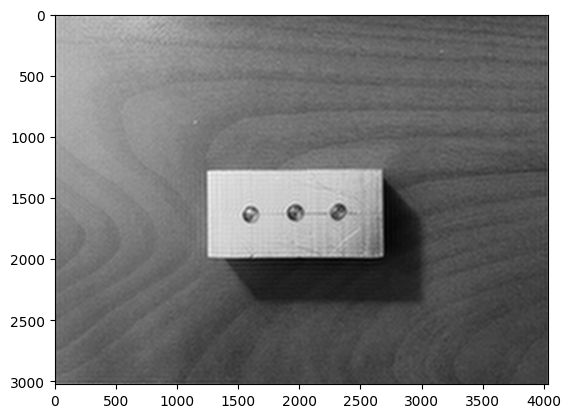

In [5]:
from matplotlib.image import HERMITE
from scipy import fft

def fft_LPF(img, r_cutoff=0.95, verbose=False):
  """ performs low pass filtering by: 1. taking fft on img (size: H,W), 2. applying a rectangular binary mask in freq domain,
      and 3. inverse fft the masked result back into position domain to get filtered image.
      r_cutoff (float in [0,1]) defines the size of the rectangular freq domain mask
      (height = H*r_cutoff, width = W*r_cutoff, centered at origin of freq domain);
      only components inside the mask are kept
  """

  # get image size
  if img.ndim == 3:   # colored image (BGR)
    H,W,C = img.shape
  else:   # single channel (grey scale)
    H,W = img.shape
    C = 1

  # find center coord
  hc = (H-1)/2.
  wc = (W-1)/2.

  # 2D fourier transform
  f_img = fft.fft2(img)

  # shift 0-freq to center of f_img
  f_img = fft.fftshift(f_img)

  # define frequency domain mask
  # find cutoff boundaries
  wl = int(wc * r_cutoff)
  wu = int(wc * (2 - r_cutoff)) +1
  hl = int(hc * r_cutoff)
  hu = int(hc * (2 - r_cutoff)) +1
  # build mask
  mask = np.zeros_like(img)
  mask[hl:hu+1 , wl:wu+1] = 1

  # # TEST: guass blur mask
  # k=100
  # mask = cv2.GaussianBlur(mask, ksize=(2*k+1,2*k+1), sigmaX=k, sigmaY=k)

  if verbose:
    print(f"input image size: W,H = ({W}, {H})")
    print(f"cutoff limits: width:({wl}, {wu}), height:({hl}, {hu})")

  # apply mask
  f_filtered = f_img * mask
  # f_filtered = f_img

  if verbose:
    # TODO: show freq domain filtered results
    pass

  # inverse 2D fourier transform
  filtered = fft.ifft2(f_filtered)
  # filtered = fft.fftshift(filtered)
  filtered = np.abs(filtered).astype(np.uint8)

  return filtered



filtered = fft_LPF(original)

# plt.imshow(mask, cmap='gray', vmin=0, vmax=1)

print("result:")
plt.imshow(filtered, cmap='gray')

Forcefully filtering by throwing away everything beyond the cutoff freq in freq domain will cause ripples in position domain; will need to filter smoothly in freq domain. TODO: implement butterworth filtering

## Compare against Gaussian filtering

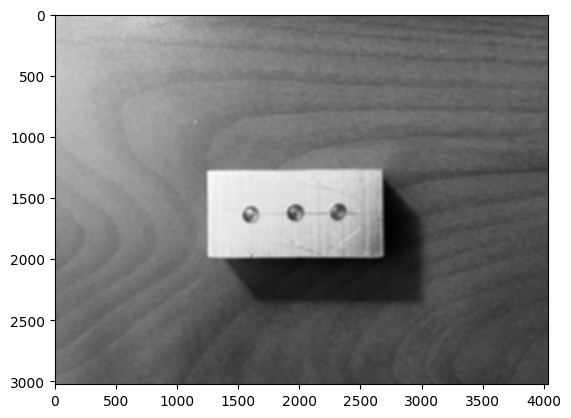

In [42]:
k = 31
s = 30

filtered_gauss = cv2.GaussianBlur(original, ksize=(k,k), sigmaX=s, sigmaY=s)
plt.imshow(filtered_gauss, cmap='gray')

# Gradient

## Preprocessing Module (copied)

In [7]:
def gradient(img, derv_len=1, use_sobel=False):
    """ takes gradient of the input image (img); returns superscored edge map and directional derivatives.
        img can have 1 channel (greyscale) or 3 channels (color)
    """
    # check input dimensions
    shape = img.shape
    combine_channels = True     # flag: perform edge combination along channels
    if len(shape) == 2:     # grey scale
        combine_channels = False

    # define derivative filters
    if use_sobel:
        dfdx = cv2.Sobel(img, ddepth=-1, dx=1, dy=0, ksize=2*derv_len+1)
        dfdy = cv2.Sobel(img, ddepth=-1, dx=0, dy=1, ksize=2*derv_len+1)
    else:  # use simple derivative
        # dx = np.array([[-1, 1]])
        # dy = np.array([[1, -1]]).T
        ones = np.repeat(1, derv_len).reshape(1, derv_len)
        dx = np.concatenate([-ones, ones], axis=1)
        dy = np.concatenate([ones, -ones], axis=1).T

        # differentiate each color channel on each axis on both directions
        # on both directions (pos & neg) b/c we are dealing w/ uint8
        dfdx_pos = cv2.filter2D(src=img, ddepth=-1, kernel=dx)
        dfdy_pos = cv2.filter2D(src=img, ddepth=-1, kernel=dy)
        dfdx_neg = cv2.filter2D(src=img, ddepth=-1, kernel=np.flip(dx))
        dfdy_neg = cv2.filter2D(src=img, ddepth=-1, kernel=np.flip(dy))

        # merge pos & neg results on each axis
        dfdx = np.maximum(dfdx_pos, dfdx_neg)
        dfdy = np.maximum(dfdy_pos, dfdy_neg)

    # combine edge results on each direction
    out = np.maximum(dfdx, dfdy)
    # out = np.sqrt( np.power(dfdx, 2) + np.power(dfdy, 2) )

    # combine edge results on each channel
    if combine_channels:
        out = np.max(out, axis=2)

    return out, dfdx, dfdy

## Take Gradient

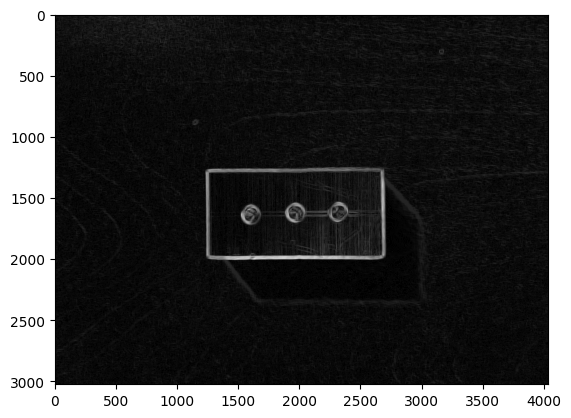

In [69]:
grad,_,_ = gradient(filtered_gauss, derv_len=1)

plt.imshow(grad, cmap='gray')

# Threshold

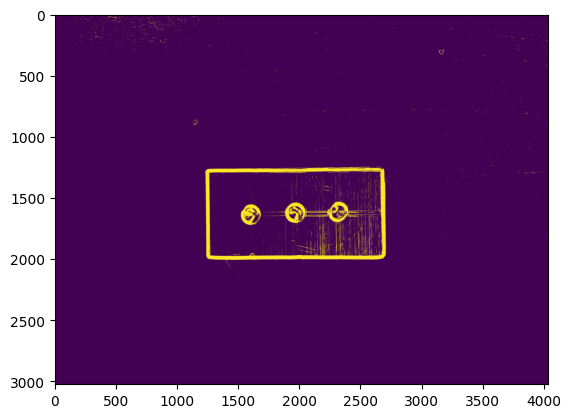

In [57]:
# threshold
p = np.percentile(grad, 90)
thrs = np.where(grad > p, 255, 0).astype(np.uint8)
plt.imshow(thrs)

#Erosion

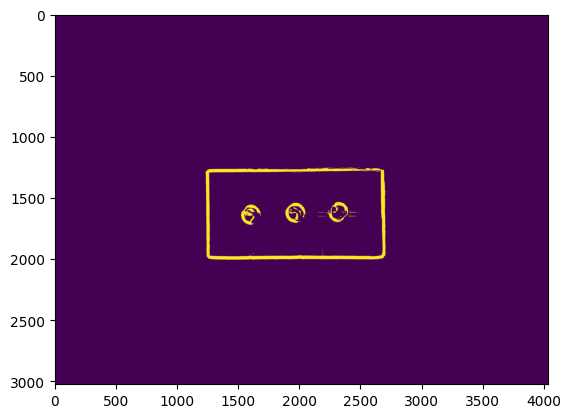

In [70]:
k = 4
eroded = cv2.erode(thrs, np.ones((k,k)))

plt.imshow(eroded)

# Bundle everything together

In [71]:
def get_edges(original):
  # LPF: gauss blur
  k = 15
  gauss = cv2.GaussianBlur(original, ksize=(2*k+1,2*k+1), sigmaX=2*k, sigmaY=2*k)
  # edge finding: gradient
  grad,_,_ = gradient(gauss)
  # refinement
  # threshold
  p = 90
  thrs = np.where(grad > np.percentile(grad, p), 255, 0).astype(np.uint8)
  # erode
  k = 4
  eroded = cv2.erode(thrs, np.ones((k, k)))

  return eroded

# Hough Transform

found 89 lines
found 14 circles


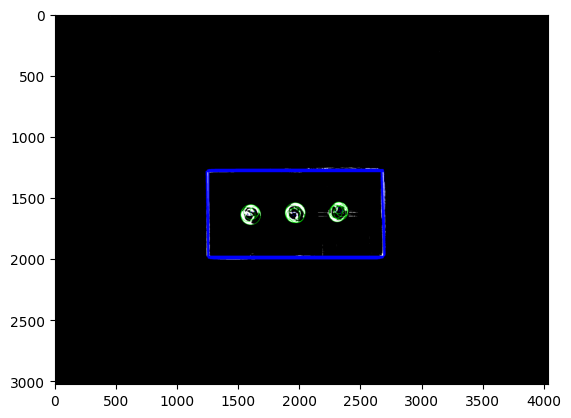

In [72]:
edges = eroded
# edges = get_edges(original)

# Find Lines
lines = cv2.HoughLinesP(edges,
                        1, np.pi/180,
                        threshold=500,    # threshold effectiveness influenced by thickness of lines, but not sensitive
                        minLineLength=10,
                        maxLineGap=1e6)

lines = [tuple(line[0]) for line in lines]
print(f"found {len(lines)} lines")

# Find Circles
r_min = 10
circles = cv2.HoughCircles(edges,
                           method=cv2.HOUGH_GRADIENT,
                           dp=1,
                           param1=100,
                           param2=40,     # param2 effectiveness influenced by completeness & thickness of circles; pretty sensitve, and seem especially sensitive to salt & pepper noise
                           minDist=2*r_min,
                           minRadius=r_min,
                           maxRadius=0)
num = 0
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    num = len(circles)
print(f"found {num} circles")

# Draw Lines
base_n_shapes = edges.copy()
base_n_shapes = cv2.cvtColor(base_n_shapes, cv2.COLOR_GRAY2BGR)
for (x1, y1, x2, y2) in lines:
    cv2.line(base_n_shapes, (x1, y1), (x2, y2), (0, 0, 255), 2)

# Draw Circles
if circles is not None:
    for (x, y, r) in circles:
        cv2.circle(base_n_shapes, (x, y), r, (0, 255, 0), 2)
        cv2.circle(base_n_shapes, (x, y), 2, (0, 0, 255), 3)

plt.imshow(base_n_shapes)